In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

2022-06-19 13:02:01.124201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-19 13:02:01.124265: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
features_num = [
    'Total_flux', 'Peak_flux', 'EBV', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68', 'Mass_u68',
        'z_rcs_flux_corr', 'z_hsc_flux_corr', 'i_hsc_flux_corr',
       'i_rcs_flux_corr', 'i_flux_corr', 'y_hsc_flux_corr', 'r_flux_corr',
       'r_hsc_flux_corr', 'r_rcs_flux_corr', 'ch1_swire_flux_corr',
       'ch2_swire_flux_corr', 'ch3_swire_flux_corr', 'ch4_swire_flux_corr',
       'ch1_servs_flux_corr', 'ch2_servs_flux_corr', 'g_flux_corr',
       'g_hsc_flux_corr', 'nb921_hsc_flux_corr', 'g_rcs_flux_corr'
]
    

features_cat = [
   "S_Code"
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [3]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_filled_preprocessed.csv")

In [4]:
data.columns

Index(['Source_Name', 'Total_flux', 'Peak_flux', 'S_Code', 'EBV',
       'FUV_flux_corr', 'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr',
       'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr',
       'y_flux_corr', 'J_flux_corr', 'H_flux_corr', 'K_flux_corr',
       'Ks_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250',
       'F_SPIRE_350', 'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68',
       'Mass_u68', 'Source', 'AGN_final', 'RadioAGN_final', 'Classification',
       'Radio_excess', 'AGNfrac_af', 'AGNfrac_af_16', 'AGNfrac_cg_s_16',
       'z_rcs_flux_corr', 'z_hsc_flux_corr', 'i_hsc_flux_corr',
       'i_rcs_flux_corr', 'i_flux_corr', 'y_hsc_flux_corr', 'r_flux_corr',
       'r_hsc_flux_corr', 'r_rcs_flux_corr', 'ch1_swire_flux_corr',
       'ch2_swire_flux_corr', 'ch3_swire_flux_corr', 'ch4_swire_flux_corr',
       'ch1_servs_flux_corr', 'ch2_servs_flux_corr', 'g_flu

In [5]:
data.isna().sum()

Source_Name            0
Total_flux             0
Peak_flux              0
S_Code                 0
EBV                    0
FUV_flux_corr          0
NUV_flux_corr          0
u_flux_corr            0
Bw_flux_corr           0
R_flux_corr            0
I_flux_corr            0
z_flux_corr            0
z_Subaru_flux_corr     0
y_flux_corr            0
J_flux_corr            0
H_flux_corr            0
K_flux_corr            0
Ks_flux_corr           0
ch1_flux_corr          0
ch2_flux_corr          0
ch3_flux_corr          0
ch4_flux_corr          0
F_MIPS_24              0
F_PACS_100             0
F_PACS_160             0
F_SPIRE_250            0
F_SPIRE_350            0
F_SPIRE_500            0
Z_BEST                 0
Mass_median            0
Mass_l68               0
Mass_u68               0
Source                 0
AGN_final              0
RadioAGN_final         0
Classification         0
Radio_excess           0
AGNfrac_af             0
AGNfrac_af_16          0
AGNfrac_cg_s_16        0


In [6]:
X = data[np.append(features_num, features_cat)]
y = data[y_column]

In [7]:
le = LabelEncoder()
labels = np.unique(y.astype(str))
y = le.fit_transform(y)

In [8]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [9]:
def one_hot(df, columns):
    """
    One-hot encoding a certain column in a dataframe
    """
    one_hot = pd.get_dummies(df[columns])
    df = df.drop(columns=columns, axis = 1)
    df = df.join(one_hot)
    return df

In [10]:
# Imputing missing categorical features
imp = SimpleImputer(strategy="most_frequent")

# Transforming the categorical data
X_train[features_cat] = imp.fit_transform(X_train[features_cat])
X_test[features_cat] = imp.transform(X_test[features_cat])

# One-hot encoding categorical features
X_train = one_hot(X_train, features_cat)
X_test = one_hot(X_test, features_cat)

# Standard scaling the numerical data
scaler = MinMaxScaler()

# Transforming the categorical data
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

# Random forest

In [14]:
clf = RandomForestClassifier(n_estimators=50, 
                             max_features=None,
                             n_jobs=-1, 
                             class_weight="balanced", 
                             random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=None,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [195]:
cv_score = cross_val_score(clf, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [196]:
print("Cross-validated Accuracy:", round(np.mean(cv_score), 5), "±", round(np.std(cv_score), 5))

Cross-validated Accuracy: 0.83311 ± 0.01399


In [15]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7948    0.5688    0.6631      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5055    0.1704    0.2548       270
                                     radio-quiet AGN     0.7060    0.5509    0.6189      1356
                                 star-forming galaxy     0.8587    0.9506    0.9023     11315

                                            accuracy                         0.8386     15522
                                           macro avg     0.7163    0.5602    0.6098     15522
                                        weighted avg     0.8286    0.8386    0.8265     15522



[]

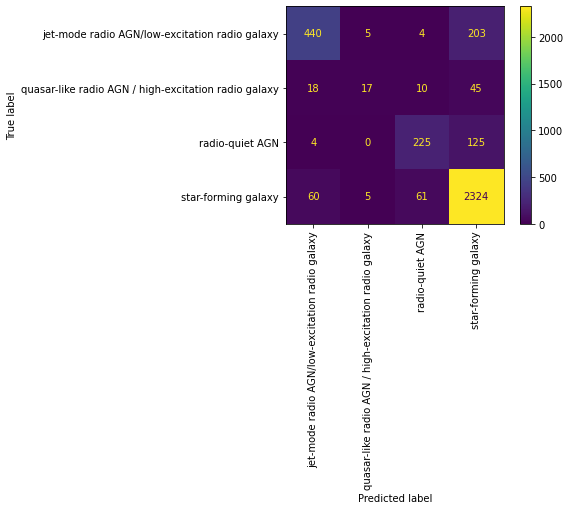

In [211]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# Lightgbm

In [229]:
import lightgbm as lgb
lightbm = lgb.LGBMClassifier(num_class=4, 
                             objective="multiclass",  
                             n_estimators=200, 
                             class_weight="balanced",
                             max_depth=7, 
                             num_leaves=32, 
                             min_child_samples=5,
                             reg_alpha=1,
                             reg_lambda=2)

In [230]:
lightbm.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', max_depth=8, min_child_samples=5,
               n_estimators=200, num_class=4, num_leaves=32,
               objective='multiclass', reg_alpha=1, reg_lambda=2)

In [231]:
cv_score_lgb = cross_val_score(lightbm, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [232]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_lgb), 5), "±", round(np.std(cv_score_lgb), 5))

Cross-validated Accuracy: 0.87436 ± 0.01571


In [233]:
y_pred = lightbm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8178    0.8604    0.8386       652
quasar-like radio AGN / high-excitation radio galaxy     0.5536    0.3444    0.4247        90
                                     radio-quiet AGN     0.6752    0.8220    0.7414       354
                                 star-forming galaxy     0.9410    0.9114    0.9260      2450

                                            accuracy                         0.8787      3546
                                           macro avg     0.7469    0.7346    0.7327      3546
                                        weighted avg     0.8820    0.8787    0.8788      3546



[]

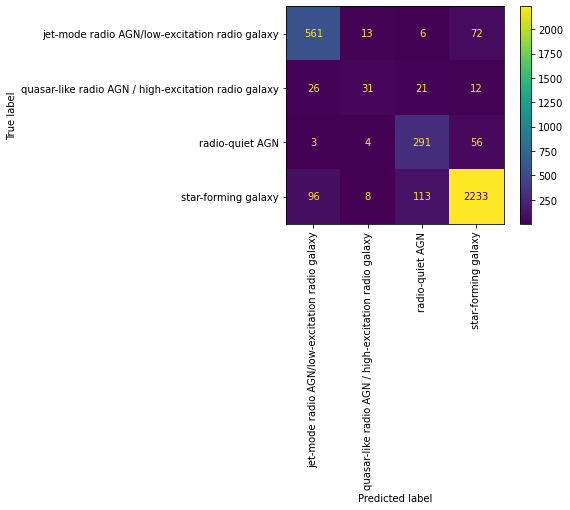

In [234]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# XGBoost

In [44]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=8, 
                      reg_alpha=0, 
                      min_child_weight=0.5, 
                      reg_lambda=1,
                      eta=0.3,
                      tree_method='exact',
                      eval_metric=['merror', 'auc'],
                      objective='multi:softprob',
                      n_estimators=10000, 
                      early_stopping_rounds=50)
bst = model.fit(X_train, y_train, 
                eval_set=[(X_test, y_test)], verbose=True, 
                sample_weight=classes_weights) # Maybe remove weight

[0]	validation_0-merror:0.23721	validation_0-mlogloss:1.14156	validation_0-auc:0.88906
[1]	validation_0-merror:0.21917	validation_0-mlogloss:0.98783	validation_0-auc:0.90375
[2]	validation_0-merror:0.21685	validation_0-mlogloss:0.88707	validation_0-auc:0.90804
[3]	validation_0-merror:0.20977	validation_0-mlogloss:0.81172	validation_0-auc:0.91393
[4]	validation_0-merror:0.20564	validation_0-mlogloss:0.75334	validation_0-auc:0.91792
[5]	validation_0-merror:0.20171	validation_0-mlogloss:0.70919	validation_0-auc:0.92106
[6]	validation_0-merror:0.19894	validation_0-mlogloss:0.67181	validation_0-auc:0.92392
[7]	validation_0-merror:0.19385	validation_0-mlogloss:0.64250	validation_0-auc:0.92658
[8]	validation_0-merror:0.19160	validation_0-mlogloss:0.61925	validation_0-auc:0.92920
[9]	validation_0-merror:0.18754	validation_0-mlogloss:0.59924	validation_0-auc:0.93134
[10]	validation_0-merror:0.18548	validation_0-mlogloss:0.58208	validation_0-auc:0.93341
[11]	validation_0-merror:0.18445	validatio

[94]	validation_0-merror:0.12904	validation_0-mlogloss:0.34290	validation_0-auc:0.96184
[95]	validation_0-merror:0.12853	validation_0-mlogloss:0.34194	validation_0-auc:0.96200
[96]	validation_0-merror:0.12866	validation_0-mlogloss:0.34125	validation_0-auc:0.96205
[97]	validation_0-merror:0.12866	validation_0-mlogloss:0.34041	validation_0-auc:0.96205
[98]	validation_0-merror:0.12801	validation_0-mlogloss:0.33878	validation_0-auc:0.96226
[99]	validation_0-merror:0.12769	validation_0-mlogloss:0.33745	validation_0-auc:0.96244
[100]	validation_0-merror:0.12801	validation_0-mlogloss:0.33677	validation_0-auc:0.96251
[101]	validation_0-merror:0.12756	validation_0-mlogloss:0.33567	validation_0-auc:0.96269
[102]	validation_0-merror:0.12775	validation_0-mlogloss:0.33549	validation_0-auc:0.96265
[103]	validation_0-merror:0.12711	validation_0-mlogloss:0.33442	validation_0-auc:0.96277
[104]	validation_0-merror:0.12672	validation_0-mlogloss:0.33365	validation_0-auc:0.96284
[105]	validation_0-merror:0

[187]	validation_0-merror:0.11165	validation_0-mlogloss:0.30270	validation_0-auc:0.96507
[188]	validation_0-merror:0.11184	validation_0-mlogloss:0.30271	validation_0-auc:0.96506
[189]	validation_0-merror:0.11216	validation_0-mlogloss:0.30243	validation_0-auc:0.96513
[190]	validation_0-merror:0.11191	validation_0-mlogloss:0.30226	validation_0-auc:0.96512
[191]	validation_0-merror:0.11229	validation_0-mlogloss:0.30221	validation_0-auc:0.96513
[192]	validation_0-merror:0.11197	validation_0-mlogloss:0.30220	validation_0-auc:0.96508
[193]	validation_0-merror:0.11184	validation_0-mlogloss:0.30209	validation_0-auc:0.96506
[194]	validation_0-merror:0.11158	validation_0-mlogloss:0.30183	validation_0-auc:0.96510
[195]	validation_0-merror:0.11145	validation_0-mlogloss:0.30155	validation_0-auc:0.96512
[196]	validation_0-merror:0.11171	validation_0-mlogloss:0.30128	validation_0-auc:0.96516
[197]	validation_0-merror:0.11139	validation_0-mlogloss:0.30094	validation_0-auc:0.96523
[198]	validation_0-me

[280]	validation_0-merror:0.10727	validation_0-mlogloss:0.29481	validation_0-auc:0.96634
[281]	validation_0-merror:0.10694	validation_0-mlogloss:0.29480	validation_0-auc:0.96633
[282]	validation_0-merror:0.10720	validation_0-mlogloss:0.29477	validation_0-auc:0.96632
[283]	validation_0-merror:0.10727	validation_0-mlogloss:0.29458	validation_0-auc:0.96638
[284]	validation_0-merror:0.10733	validation_0-mlogloss:0.29459	validation_0-auc:0.96638
[285]	validation_0-merror:0.10727	validation_0-mlogloss:0.29463	validation_0-auc:0.96638
[286]	validation_0-merror:0.10701	validation_0-mlogloss:0.29462	validation_0-auc:0.96639
[287]	validation_0-merror:0.10733	validation_0-mlogloss:0.29462	validation_0-auc:0.96639
[288]	validation_0-merror:0.10733	validation_0-mlogloss:0.29457	validation_0-auc:0.96641
[289]	validation_0-merror:0.10714	validation_0-mlogloss:0.29445	validation_0-auc:0.96644
[290]	validation_0-merror:0.10701	validation_0-mlogloss:0.29435	validation_0-auc:0.96647
[291]	validation_0-me

[373]	validation_0-merror:0.10224	validation_0-mlogloss:0.29658	validation_0-auc:0.96732
[374]	validation_0-merror:0.10224	validation_0-mlogloss:0.29688	validation_0-auc:0.96729
[375]	validation_0-merror:0.10198	validation_0-mlogloss:0.29685	validation_0-auc:0.96731
[376]	validation_0-merror:0.10198	validation_0-mlogloss:0.29688	validation_0-auc:0.96732
[377]	validation_0-merror:0.10192	validation_0-mlogloss:0.29713	validation_0-auc:0.96728
[378]	validation_0-merror:0.10211	validation_0-mlogloss:0.29707	validation_0-auc:0.96731
[379]	validation_0-merror:0.10211	validation_0-mlogloss:0.29709	validation_0-auc:0.96732
[380]	validation_0-merror:0.10224	validation_0-mlogloss:0.29716	validation_0-auc:0.96732
[381]	validation_0-merror:0.10173	validation_0-mlogloss:0.29721	validation_0-auc:0.96735
[382]	validation_0-merror:0.10205	validation_0-mlogloss:0.29744	validation_0-auc:0.96734
[383]	validation_0-merror:0.10211	validation_0-mlogloss:0.29760	validation_0-auc:0.96734
[384]	validation_0-me

[466]	validation_0-merror:0.10128	validation_0-mlogloss:0.30497	validation_0-auc:0.96771
[467]	validation_0-merror:0.10128	validation_0-mlogloss:0.30502	validation_0-auc:0.96771
[468]	validation_0-merror:0.10121	validation_0-mlogloss:0.30510	validation_0-auc:0.96771
[469]	validation_0-merror:0.10128	validation_0-mlogloss:0.30516	validation_0-auc:0.96772
[470]	validation_0-merror:0.10121	validation_0-mlogloss:0.30526	validation_0-auc:0.96772
[471]	validation_0-merror:0.10128	validation_0-mlogloss:0.30533	validation_0-auc:0.96772
[472]	validation_0-merror:0.10147	validation_0-mlogloss:0.30534	validation_0-auc:0.96774
[473]	validation_0-merror:0.10147	validation_0-mlogloss:0.30545	validation_0-auc:0.96774
[474]	validation_0-merror:0.10134	validation_0-mlogloss:0.30564	validation_0-auc:0.96772
[475]	validation_0-merror:0.10147	validation_0-mlogloss:0.30566	validation_0-auc:0.96773
[476]	validation_0-merror:0.10134	validation_0-mlogloss:0.30577	validation_0-auc:0.96773
[477]	validation_0-me

[559]	validation_0-merror:0.10173	validation_0-mlogloss:0.31375	validation_0-auc:0.96814
[560]	validation_0-merror:0.10121	validation_0-mlogloss:0.31389	validation_0-auc:0.96815
[561]	validation_0-merror:0.10134	validation_0-mlogloss:0.31402	validation_0-auc:0.96815
[562]	validation_0-merror:0.10134	validation_0-mlogloss:0.31413	validation_0-auc:0.96814
[563]	validation_0-merror:0.10140	validation_0-mlogloss:0.31416	validation_0-auc:0.96815
[564]	validation_0-merror:0.10166	validation_0-mlogloss:0.31422	validation_0-auc:0.96816
[565]	validation_0-merror:0.10173	validation_0-mlogloss:0.31417	validation_0-auc:0.96818
[566]	validation_0-merror:0.10166	validation_0-mlogloss:0.31434	validation_0-auc:0.96818
[567]	validation_0-merror:0.10192	validation_0-mlogloss:0.31447	validation_0-auc:0.96818
[568]	validation_0-merror:0.10166	validation_0-mlogloss:0.31449	validation_0-auc:0.96819
[569]	validation_0-merror:0.10160	validation_0-mlogloss:0.31458	validation_0-auc:0.96820
[570]	validation_0-me

[652]	validation_0-merror:0.10082	validation_0-mlogloss:0.32354	validation_0-auc:0.96835
[653]	validation_0-merror:0.10063	validation_0-mlogloss:0.32359	validation_0-auc:0.96834
[654]	validation_0-merror:0.10121	validation_0-mlogloss:0.32361	validation_0-auc:0.96835
[655]	validation_0-merror:0.10121	validation_0-mlogloss:0.32372	validation_0-auc:0.96836
[656]	validation_0-merror:0.10115	validation_0-mlogloss:0.32389	validation_0-auc:0.96837
[657]	validation_0-merror:0.10089	validation_0-mlogloss:0.32404	validation_0-auc:0.96836
[658]	validation_0-merror:0.10095	validation_0-mlogloss:0.32416	validation_0-auc:0.96836
[659]	validation_0-merror:0.10102	validation_0-mlogloss:0.32430	validation_0-auc:0.96836
[660]	validation_0-merror:0.10102	validation_0-mlogloss:0.32442	validation_0-auc:0.96836
[661]	validation_0-merror:0.10115	validation_0-mlogloss:0.32440	validation_0-auc:0.96837
[662]	validation_0-merror:0.10121	validation_0-mlogloss:0.32454	validation_0-auc:0.96838
[663]	validation_0-me

[745]	validation_0-merror:0.10005	validation_0-mlogloss:0.33259	validation_0-auc:0.96858
[746]	validation_0-merror:0.10044	validation_0-mlogloss:0.33277	validation_0-auc:0.96856
[747]	validation_0-merror:0.10031	validation_0-mlogloss:0.33294	validation_0-auc:0.96855
[748]	validation_0-merror:0.10044	validation_0-mlogloss:0.33305	validation_0-auc:0.96854
[749]	validation_0-merror:0.10024	validation_0-mlogloss:0.33316	validation_0-auc:0.96854
[750]	validation_0-merror:0.10018	validation_0-mlogloss:0.33326	validation_0-auc:0.96854
[751]	validation_0-merror:0.10044	validation_0-mlogloss:0.33331	validation_0-auc:0.96855
[752]	validation_0-merror:0.10018	validation_0-mlogloss:0.33348	validation_0-auc:0.96854
[753]	validation_0-merror:0.10018	validation_0-mlogloss:0.33365	validation_0-auc:0.96853
[754]	validation_0-merror:0.10024	validation_0-mlogloss:0.33378	validation_0-auc:0.96853
[755]	validation_0-merror:0.10031	validation_0-mlogloss:0.33384	validation_0-auc:0.96853
[756]	validation_0-me

In [225]:
cv_score_xgb = cross_val_score(model, X_train, y_train, cv=8, n_jobs=-1, scoring="accuracy")

In [123]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

NameError: name 'cv_score_xgb' is not defined

In [45]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8376    0.8311    0.8343      2581
quasar-like radio AGN / high-excitation radio galaxy     0.6185    0.3963    0.4831       270
                                     radio-quiet AGN     0.7507    0.7552    0.7529      1356
                                 star-forming galaxy     0.9362    0.9452    0.9407     11315

                                            accuracy                         0.9001     15522
                                           macro avg     0.7857    0.7319    0.7527     15522
                                        weighted avg     0.8981    0.9001    0.8986     15522



[]

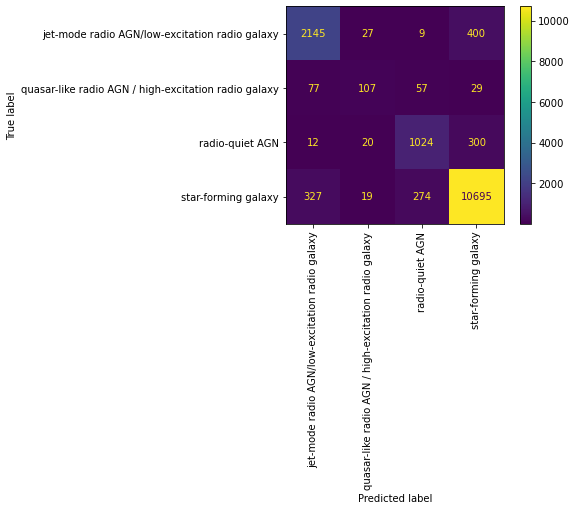

In [47]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

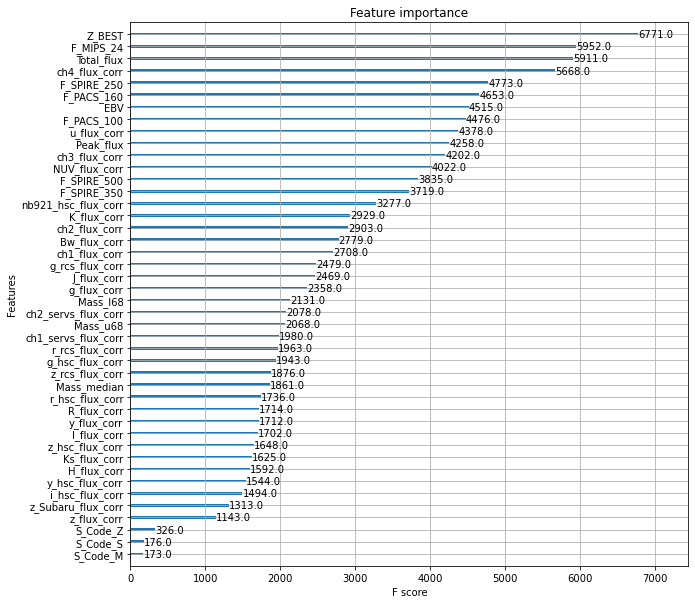

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

## Hyperparameter fitting

In [11]:
import multiprocessing

multiprocessing.cpu_count()

192

In [12]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [13]:
# Metrics for hyperparameter tuning
metrics = {"Accuracy": "accuracy",
          "Balanced accuracy": "balanced_accuracy",
          "F1 score": "f1_weighted"}

In [14]:
# Parameter space
parameters = { 
         "max_depth": [8,9,10,11],
         "reg_alpha": [0,1,3,5], 
        "reg_lambda": [0,1,3,5],
        "gamma": [0,0.5,3],
        "eta": [0.1, 0.3],
        "min_child_weight": [0, 0.2, 0.5, 1]}

In [15]:
model = XGBClassifier(use_label_encoder=False,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=1000, 
                      early_stopping_rounds=30,)

In [16]:
clf = GridSearchCV(estimator=model, 
                   param_grid=parameters,
                  scoring=metrics,
                  refit="Accuracy",
                  return_train_score=True,
                  n_jobs=128,
                  cv=2,
                  verbose=1)

grid = clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

Fitting 2 folds for each of 1536 candidates, totalling 3072 fits


/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [17]:
clf.best_params_, clf.best_score_

({'eta': 0.1,
  'gamma': 0,
  'max_depth': 8,
  'min_child_weight': 0.5,
  'reg_alpha': 0,
  'reg_lambda': 1},
 0.8939391641429841)

In [ ]:
bui{'eta': 0.1,
  'gamma': 0,
  'max_depth': 8,
  'min_child_weight': 0.5,
  'reg_alpha': 0,
  'reg_lambda': 1},
 0.8939391641429841

In [20]:
model = XGBClassifier(use_label_encoder=False,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=400, 
                     **clf.best_params_)

In [21]:
cv_score_xgb = cross_val_score(model, X_train, y_train, cv=32,  n_jobs=32, scoring="accuracy")

In [22]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

Cross-validated Accuracy: 0.89821 ± 0.00676


In [35]:
model = XGBClassifier(use_label_encoder=False,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=1000, 
                      early_stopping_rounds=30,
                     **clf.best_params_)

In [36]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# DNN

In [27]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dic = {i:class_weight[i] for i in range(4)}

In [28]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(4),
    ]
)

2022-06-19 17:41:31.576830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-19 17:41:31.585914: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-19 17:41:31.585970: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub1.intra.astro.rug.nl): /proc/driver/nvidia/version does not exist
2022-06-19 17:41:31.592309: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="Adam",
    metrics=["accuracy"],
)

In [34]:
model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=1000,
    #callbacks=callbacks,
    validation_data=(X_test, y_test),
    #class_weight=class_weight_dic,
)

Epoch 1/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4616 - accuracy: 0.8264 - val_loss: 0.4683 - val_accuracy: 0.8280
Epoch 2/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.4607 - accuracy: 0.8268 - val_loss: 0.4731 - val_accuracy: 0.8235
Epoch 3/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.4582 - accuracy: 0.8268 - val_loss: 0.4658 - val_accuracy: 0.8298
Epoch 4/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4562 - accuracy: 0.8284 - val_loss: 0.4708 - val_accuracy: 0.8295
Epoch 5/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4564 - accuracy: 0.8285 - val_loss: 0.4737 - val_accuracy: 0.8252
Epoch 6/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4563 - accuracy: 0.8287 - val_loss: 0.4643 - val_accuracy: 0.8292
Epoch 7/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4524 - accuracy: 0.8292 - val_loss: 0.4653 - val_accuracy: 0.8304

Epoch 58/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4385 - accuracy: 0.8332 - val_loss: 0.4532 - val_accuracy: 0.8308
Epoch 59/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4398 - accuracy: 0.8328 - val_loss: 0.4571 - val_accuracy: 0.8300
Epoch 60/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.4386 - accuracy: 0.8330 - val_loss: 0.4610 - val_accuracy: 0.8302
Epoch 61/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4393 - accuracy: 0.8341 - val_loss: 0.4660 - val_accuracy: 0.8293
Epoch 62/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4347 - accuracy: 0.8351 - val_loss: 0.4576 - val_accuracy: 0.8315
Epoch 63/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4350 - accuracy: 0.8349 - val_loss: 0.4617 - val_accuracy: 0.8306
Epoch 64/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4370 - accuracy: 0.8340 - val_loss: 0.4598 - val_accuracy:

Epoch 115/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4234 - accuracy: 0.8381 - val_loss: 0.4549 - val_accuracy: 0.8353
Epoch 116/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4273 - accuracy: 0.8377 - val_loss: 0.4476 - val_accuracy: 0.8364
Epoch 117/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4231 - accuracy: 0.8385 - val_loss: 0.4514 - val_accuracy: 0.8333
Epoch 118/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4255 - accuracy: 0.8380 - val_loss: 0.4704 - val_accuracy: 0.8318
Epoch 119/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4251 - accuracy: 0.8375 - val_loss: 0.4598 - val_accuracy: 0.8327
Epoch 120/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4230 - accuracy: 0.8393 - val_loss: 0.4579 - val_accuracy: 0.8313
Epoch 121/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.4193 - accuracy: 0.8384 - val_loss: 0.4482 - val_ac

61/61 [==============================] - 1s 14ms/step - loss: 0.4157 - accuracy: 0.8410 - val_loss: 0.4570 - val_accuracy: 0.8333
Epoch 172/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4217 - accuracy: 0.8390 - val_loss: 0.4451 - val_accuracy: 0.8363
Epoch 173/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4123 - accuracy: 0.8423 - val_loss: 0.4486 - val_accuracy: 0.8386
Epoch 174/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4136 - accuracy: 0.8423 - val_loss: 0.4502 - val_accuracy: 0.8346
Epoch 175/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4142 - accuracy: 0.8407 - val_loss: 0.4559 - val_accuracy: 0.8371
Epoch 176/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4131 - accuracy: 0.8422 - val_loss: 0.4577 - val_accuracy: 0.8352
Epoch 177/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4184 - accuracy: 0.8412 - val_loss: 0.4575 - val_accuracy: 0.8355


61/61 [==============================] - 1s 14ms/step - loss: 0.4075 - accuracy: 0.8439 - val_loss: 0.4569 - val_accuracy: 0.8364
Epoch 228/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4068 - accuracy: 0.8451 - val_loss: 0.4721 - val_accuracy: 0.8315
Epoch 229/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4082 - accuracy: 0.8439 - val_loss: 0.4529 - val_accuracy: 0.8390
Epoch 230/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4120 - accuracy: 0.8418 - val_loss: 0.4585 - val_accuracy: 0.8366
Epoch 231/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4054 - accuracy: 0.8451 - val_loss: 0.4496 - val_accuracy: 0.8396
Epoch 232/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4064 - accuracy: 0.8453 - val_loss: 0.4519 - val_accuracy: 0.8396
Epoch 233/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4056 - accuracy: 0.8446 - val_loss: 0.4718 - val_accuracy: 0.8378


61/61 [==============================] - 1s 14ms/step - loss: 0.4011 - accuracy: 0.8472 - val_loss: 0.4483 - val_accuracy: 0.8399
Epoch 284/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4013 - accuracy: 0.8462 - val_loss: 0.4539 - val_accuracy: 0.8376
Epoch 285/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4012 - accuracy: 0.8467 - val_loss: 0.4539 - val_accuracy: 0.8396
Epoch 286/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4043 - accuracy: 0.8466 - val_loss: 0.4569 - val_accuracy: 0.8391
Epoch 287/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4009 - accuracy: 0.8461 - val_loss: 0.4542 - val_accuracy: 0.8391
Epoch 288/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.3992 - accuracy: 0.8460 - val_loss: 0.4518 - val_accuracy: 0.8398
Epoch 289/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4020 - accuracy: 0.8458 - val_loss: 0.4583 - val_accuracy: 0.8378


61/61 [==============================] - 1s 15ms/step - loss: 0.3941 - accuracy: 0.8488 - val_loss: 0.4625 - val_accuracy: 0.8371
Epoch 340/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3938 - accuracy: 0.8495 - val_loss: 0.4585 - val_accuracy: 0.8398
Epoch 341/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.3955 - accuracy: 0.8480 - val_loss: 0.4662 - val_accuracy: 0.8378
Epoch 342/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.4020 - accuracy: 0.8469 - val_loss: 0.4611 - val_accuracy: 0.8373
Epoch 343/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3962 - accuracy: 0.8473 - val_loss: 0.4532 - val_accuracy: 0.8393
Epoch 344/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.4008 - accuracy: 0.8467 - val_loss: 0.4657 - val_accuracy: 0.8378
Epoch 345/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3928 - accuracy: 0.8490 - val_loss: 0.4636 - val_accuracy: 0.8362


61/61 [==============================] - 1s 14ms/step - loss: 0.3904 - accuracy: 0.8496 - val_loss: 0.4607 - val_accuracy: 0.8402
Epoch 396/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3910 - accuracy: 0.8517 - val_loss: 0.4793 - val_accuracy: 0.8381
Epoch 397/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.3896 - accuracy: 0.8504 - val_loss: 0.4592 - val_accuracy: 0.8400
Epoch 398/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3915 - accuracy: 0.8489 - val_loss: 0.4611 - val_accuracy: 0.8391
Epoch 399/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3923 - accuracy: 0.8483 - val_loss: 0.4656 - val_accuracy: 0.8397
Epoch 400/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3938 - accuracy: 0.8493 - val_loss: 0.4662 - val_accuracy: 0.8411
Epoch 401/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3918 - accuracy: 0.8505 - val_loss: 0.4577 - val_accuracy: 0.8419


61/61 [==============================] - 1s 15ms/step - loss: 0.3888 - accuracy: 0.8506 - val_loss: 0.4730 - val_accuracy: 0.8395
Epoch 452/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3906 - accuracy: 0.8513 - val_loss: 0.4672 - val_accuracy: 0.8384
Epoch 453/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3889 - accuracy: 0.8511 - val_loss: 0.4620 - val_accuracy: 0.8404
Epoch 454/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.3875 - accuracy: 0.8506 - val_loss: 0.4638 - val_accuracy: 0.8403
Epoch 455/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3925 - accuracy: 0.8497 - val_loss: 0.4619 - val_accuracy: 0.8396
Epoch 456/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3852 - accuracy: 0.8509 - val_loss: 0.4808 - val_accuracy: 0.8387
Epoch 457/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3888 - accuracy: 0.8498 - val_loss: 0.4678 - val_accuracy: 0.8383


61/61 [==============================] - 1s 14ms/step - loss: 0.3850 - accuracy: 0.8514 - val_loss: 0.4622 - val_accuracy: 0.8394
Epoch 508/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3843 - accuracy: 0.8531 - val_loss: 0.4661 - val_accuracy: 0.8382
Epoch 509/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.3840 - accuracy: 0.8521 - val_loss: 0.4764 - val_accuracy: 0.8376
Epoch 510/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3842 - accuracy: 0.8524 - val_loss: 0.4682 - val_accuracy: 0.8386
Epoch 511/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.3828 - accuracy: 0.8522 - val_loss: 0.4679 - val_accuracy: 0.8404
Epoch 512/1000
61/61 [==============================] - 1s 15ms/step - loss: 0.3856 - accuracy: 0.8510 - val_loss: 0.4732 - val_accuracy: 0.8372
Epoch 513/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.3859 - accuracy: 0.8513 - val_loss: 0.4844 - val_accuracy: 0.8371


KeyboardInterrupt: 